<a href="https://colab.research.google.com/github/Polinez/ImageClassification/blob/main/Klasyfikacja_Pokemonow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie bazy danych
pobieramy baze z dysku google ktora jest juz posortowana na podkatalogi

In [5]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre

#usuwanie i tworzenie pustego katalogu data
!rm -rf data && rm -rf content && mkdir data

#pobieranie zip-a ze zdjęciami
!gdown 1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH -O data.zip

#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH
From (redirected): https://drive.google.com/uc?id=1B2VsNDlaKiND2qa_pzJnXaygihHSUcGH&confirm=t&uuid=3c4d0a94-90b3-453b-869d-77d19489c755
To: /content/data.zip
100% 411M/411M [00:04<00:00, 102MB/s] 


# Pobranie potrzebnych bibliotek oraz wizualizacja jakie dane posiadamy


## Biblioteki


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import os


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

## Ilosc zdjec

In [8]:
image_count = len(list(glob.glob('data/**/*.png')))
print(f'{image_count} examples of pokemons')

26539 examples of pokemons


## Ilosc poszczegolnej klasy

In [11]:
folder_counts = dict()


for file_path in glob.glob('data/**/*.png', recursive=True):

    folder_name = os.path.basename(os.path.dirname(file_path))
    folder_counts[folder_name] = folder_counts.get(folder_name, 0) + 1


for folder, count in folder_counts.items():
    print(f'{count} examples of {folder}')

40 examples of beedrill
13 examples of cufant
20 examples of lilligant
20 examples of genesect
13 examples of drakloak
20 examples of litleo
38 examples of mawile
38 examples of makuhita
38 examples of nincada
40 examples of shiftry
6 examples of bramblin
38 examples of slakoth
38 examples of huntail
32 examples of chingling
38 examples of aggron
32 examples of probopass
20 examples of scolipede
6 examples of wugtrio
40 examples of totodile
16 examples of goodra
16 examples of gourgeist-average
6 examples of veluza
40 examples of finneon
6 examples of scovillain
20 examples of patrat
38 examples of shelgon
40 examples of suicune
16 examples of pheromosa
20 examples of whimsicott
20 examples of slurpuff
13 examples of grimmsnarl
20 examples of panpour
38 examples of treecko
40 examples of hoothoot
16 examples of furfrou
38 examples of frillish
6 examples of great-tusk
40 examples of buizel
40 examples of vaporeon
40 examples of charmander
40 examples of celebi
40 examples of qwilfish
40

## Wyswietlenie przykłądowego zdjecia

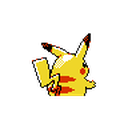

In [14]:
pikachu = list(glob.glob('data/pikachu/*'))
PIL.Image.open(str(pikachu[15]))

# Uczenie modelu

In [16]:
batch_size = 16 # liczba obrazow na raz

img_height = 128 # rozmiar obrazu po skalowaniu
img_width = 128

## Podział modelu na treninogowy i sprawdzajacy w proporccji 80 do 20

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26539 files belonging to 1000 classes.
Using 21232 files for training.
Found 26539 files belonging to 1000 classes.
Using 5307 files for validation.


In [18]:
class_names = train_ds.class_names
class_count = len(class_names)
print(f'class names: {class_names}')

class names: ['abomasnow', 'abra', 'absol', 'accelgor', 'aegislash-shield', 'aerodactyl', 'aggron', 'aipom', 'alakazam', 'alcremie', 'alomomola', 'altaria', 'amaura', 'ambipom', 'amoonguss', 'ampharos', 'annihilape', 'anorith', 'appletun', 'applin', 'araquanid', 'arbok', 'arboliva', 'arcanine', 'arceus', 'archen', 'archeops', 'arctibax', 'arctovish', 'arctozolt', 'ariados', 'armaldo', 'armarouge', 'aromatisse', 'aron', 'arrokuda', 'articuno', 'audino', 'aurorus', 'avalugg', 'axew', 'azelf', 'azumarill', 'azurill', 'bagon', 'baltoy', 'banette', 'barbaracle', 'barboach', 'barraskewda', 'basculegion-male', 'basculin-red-striped', 'bastiodon', 'baxcalibur', 'bayleef', 'beartic', 'beautifly', 'beedrill', 'beheeyem', 'beldum', 'bellibolt', 'bellossom', 'bellsprout', 'bergmite', 'bewear', 'bibarel', 'bidoof', 'binacle', 'bisharp', 'blacephalon', 'blastoise', 'blaziken', 'blipbug', 'blissey', 'blitzle', 'boldore', 'boltund', 'bombirdier', 'bonsly', 'bouffalant', 'bounsweet', 'braixen', 'brambl

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Definiujemy modele

In [25]:
def get_model(type='resnet_transfer'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


## Wybor i kompilownie modelu

In [28]:
model = get_model('custom')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         129,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,249,864 (8.58 MB)

 Trainable params: 2,249,864 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

## Trenowanie

In [29]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
 184/1327 ━━━━━━━━━━━━━━━━━━━━ 5:01 264ms/step - accuracy: 0.0016 - loss: 6.9015

KeyboardInterrupt: 

## Wyswietlanie wynikow

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))

evaluate_model(val_ds, model)